In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

%pip install -q plotnine
from plotnine import *

import tensorflow as tf
from tensorflow import keras

import math
import keras

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error

from datetime import datetime
import urllib

import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


## Get wheather data from URL

In [3]:
def get_weather_data(start_year, start_month, start_day, end_year, end_month, end_day):
    url = f'https://meteo.physic.ut.ee/et/archive.php?do=data&begin%5Byear%5D={start_year}&begin%5Bmon%5D={start_month}&begin%5Bmday%5D={start_day}&end%5Byear%5D={end_year}&end%5Bmon%5D={end_month}&end%5Bmday%5D={end_day}&9=1&12=1&10=1&15=1&16=1&14=1&ok=+Esita+p%C3%A4ring+'
    file = urllib. request. urlopen(url)
    lines = []
    for line in file:
        decoded_line = line.decode("utf-8")
        new_line = decoded_line.replace(" ","").strip()
        lines.append(new_line)
    with open('data.csv', 'w') as f:
        f.write('\n'.join(lines))
    data = pd.read_csv('data.csv')
    data.columns = ['timestamp', 'temperature', 'humidity', 'atm_pressure', 'windspeed', 'wind_direction', 'precipitation', 'radiation_flux']
    return data

In [4]:
def break_up_time(data):
    data["year"]= data.apply(lambda row: row["timestamp"][0:4], axis=1)
    data["month"] = data.apply(lambda row: row["timestamp"][5:7], axis=1)
    data["day"] = data.apply(lambda row: row["timestamp"][8:10], axis=1)
    data["hour"] = data.apply(lambda row: row["timestamp"][10:12], axis=1)
    data["minute"] = data.apply(lambda row: row["timestamp"][13:15], axis=1)
    data.year = data.year.astype('int')
    data.month = data.month.astype('int')
    data.day = data.day.astype('int')
    data.hour = data.hour.astype('int')
    data.minute = data.minute.astype('int')
    data["timestamp"] = data.apply(lambda row: datetime.strptime(row["timestamp"],"%Y-%m-%d%H:%M:%S"), axis=1)
    return data

def fill_and_correct(data):
    # if there is no rain and no snow:
    #data['snow'] = data['snow'].fillna(0)
    data['precipitation'] = data['precipitation'].fillna(0)
    # for other 
    data['windspeed'] = data['windspeed'].fillna(method='backfill')
    data['wind_direction'] = data['wind_direction'].fillna(method='backfill')
    data['temperature'] = data['temperature'].fillna(method='backfill')
    data['humidity'] = data['humidity'].fillna(method='backfill')
    data['atm_pressure'] = data['atm_pressure'].fillna(method='backfill')
    data['radiation_flux'] = data['radiation_flux'].fillna(method='backfill')
    data = data.dropna()
    return data

def cleansing(data):
    data = break_up_time(data)
    data = fill_and_correct(data)
    return data

In [5]:
data = get_weather_data(2020,12,1,2021,11,30)
data = cleansing(data)
data.sample(5)

,timestamp,temperature,humidity,atm_pressure,windspeed,wind_direction,precipitation,radiation_flux,year,month,day,hour,minute
11200,2020-12-31 11:35:00,0.589861,99.404144,1006.340200,1.148263,189.590526,0.0,25.857785,2020,12,31,11,35
45879,2021-04-30 22:30:00,5.056818,44.656159,1007.696633,2.329121,290.571137,0.0,0.109044,2021,4,30,22,30
49632,2021-05-13 23:15:00,15.510971,54.354724,1008.428533,2.812515,130.441778,0.0,0.000000,2021,5,13,23,15
48985,2021-05-11 17:20:00,24.262732,25.541340,1019.094633,5.631109,206.728219,0.0,474.787621,2021,5,11,17,20
18336,2021-01-25 06:15:00,1.666788,94.902263,994.229800,2.787307,197.301970,0.0,0.240661,2021,1,25,6,15


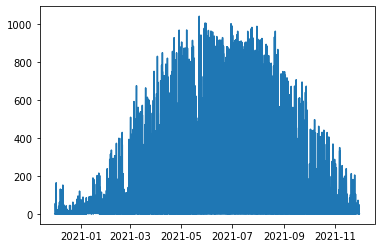

In [6]:
plt.plot(data.timestamp,data.radiation_flux)
plt.show()

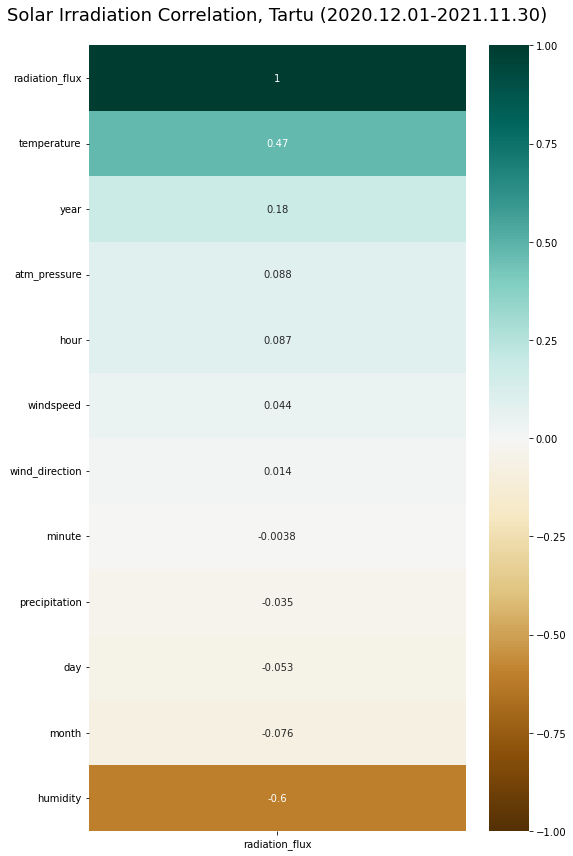

In [7]:
corr_table = data.corr()[['radiation_flux']].sort_values(by='radiation_flux', ascending=False)

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_table, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Solar Irradiation Correlation, Tartu (2020.12.01-2021.11.30)', fontdict={'fontsize':18}, pad=25)
plt.tight_layout()
plt.savefig('corr.png', dpi=300)

In [8]:
def add_shifted_col(data,col,i):
    data[f'{col}_{i}'] = data[col].shift(-i)
    return data

# Training, validation, predicting

In [9]:
def train(train_data,columns,time,model):
    i = round(time/5)
    train_data = add_shifted_col(train_data,"radiation_flux",i)
    train_data = train_data.dropna()
    X_train = train_data[columns]
    y_train = train_data[f"radiation_flux_{i}"]
    model.fit(X_train,y_train)

def test(test_data,columns,time,model):
    i = round(time/5)
    test_data = add_shifted_col(test_data,"radiation_flux",i)
    test_data = test_data.dropna()
    X_test = test_data[columns]
    y_test = test_data[f"radiation_flux_{i}"]
    s = model.score(X_test,y_test)
    return s

In [10]:
train_data = get_weather_data(2018,1,1,2021,11,30)
train_data = cleansing(train_data)
test_data = get_weather_data(2021,12,1,2021,12,10)
test_data = cleansing(test_data)

In [11]:
columns = ['year', 'month', 'day', 'hour', 'minute', # 'temperature',
        'humidity', 'atm_pressure', 'windspeed', 'wind_direction',
        'precipitation','radiation_flux'] # 

In [35]:
time = 30 # how many minutes we would like to predict?
i = round(time/5)
train_data = add_shifted_col(train_data,"radiation_flux",i)
train_data = train_data.dropna()
X_train = train_data[columns]
y_train = train_data[f"radiation_flux_{i}"]
test_data = add_shifted_col(test_data,"radiation_flux",i)
test_data = test_data.dropna()
X_test = test_data[columns]
y_test = test_data[f"radiation_flux_{i}"]

In [13]:
RFR = RandomForestRegressor(n_estimators=50,random_state=0)
RFR.fit(X_train,y_train)
y_pred_RFR = RFR.predict(X_test)
RFR.score(X_test,y_test)

0.8670319374343493

In [14]:
ETR = ExtraTreesRegressor(n_estimators=50)
ETR.fit(X_train,y_train)
y_pred_ETR_50 = ETR.predict(X_test)
ETR.score(X_test,y_test)

0.8722315424996614

In [15]:
ETR = ExtraTreesRegressor(n_estimators=60)
ETR.fit(X_train,y_train)
y_pred_ETR_60 = ETR.predict(X_test)
ETR.score(X_test,y_test)

0.8680098952244485

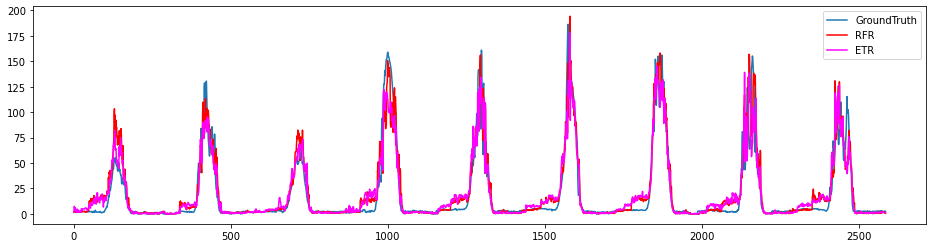

In [16]:
plt.figure(figsize=(16,4))
plt.plot(np.arange(X_test.shape[0]),y_test,label="GroundTruth")
plt.plot(np.arange(X_test.shape[0]),y_pred_RFR,color="red",label="RFR")
plt.plot(np.arange(X_test.shape[0]),y_pred_ETR_50,color="magenta",label="ETR")
plt.legend()
plt.show()

In [17]:
LinR = LinearRegression()
LinR.fit(X_train,y_train)
y_pred_LinR = LinR.predict(X_test)
LinR.score(X_test,y_test)

0.7929528636174766

In [18]:
LR = Ridge()
LR.fit(X_train,y_train)
y_pred_LR = LR.predict(X_test)
LR.score(X_test,y_test)

0.792951703110885

In [19]:
LL = Lasso()
LL.fit(X_train,y_train)
y_pred_LL = LL.predict(X_test)
LL.score(X_test,y_test)

0.794678192074573

In [20]:
E = ElasticNet()
E.fit(X_train,y_train)
y_pred_E = E.predict(X_test)
E.score(X_test,y_test)

0.7953753630369653

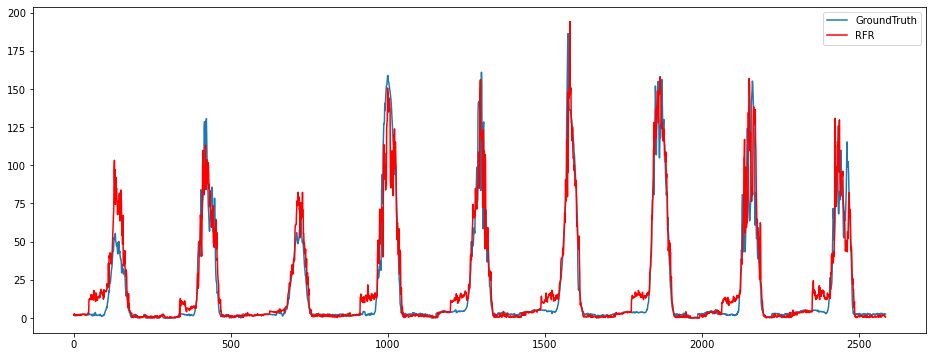

In [21]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(X_test.shape[0]),y_test,label="GroundTruth")
plt.plot(np.arange(X_test.shape[0]),y_pred_RFR,color="red",label="RFR")
#plt.plot(np.arange(X_test.shape[0]),y_pred_ETR_50,color="magenta",label="ETR")
#plt.plot(np.arange(X_test.shape[0]),y_pred_LinR,color="green",label="ETR")
#plt.plot(np.arange(X_test.shape[0]),y_pred_LR,color="orange",label="ETR")
#plt.plot(np.arange(X_test.shape[0]),y_pred_LL,color="black",label="ETR")
#plt.plot(np.arange(X_test.shape[0]),y_pred_E,color="yellow",label="ETR")
plt.legend()
plt.show()

In [22]:
rmse_RFR = np.sqrt(mean_squared_error(y_test, y_pred_RFR))
rmse_ETR_50 = np.sqrt(mean_squared_error(y_test, y_pred_ETR_50))
rmse_ETR_60 = np.sqrt(mean_squared_error(y_test, y_pred_ETR_60))
rmse_LinR = np.sqrt(mean_squared_error(y_test, y_pred_LinR))
rmse_LR = np.sqrt(mean_squared_error(y_test, y_pred_LR))
rmse_LL = np.sqrt(mean_squared_error(y_test, y_pred_LL))
rmse_E = np.sqrt(mean_squared_error(y_test, y_pred_E))
rmse_RFR,rmse_ETR_50,rmse_ETR_60,rmse_LinR,rmse_LR,rmse_LL,rmse_E


(12.779686441485564,
 12.527325262399357,
 12.732603485138645,
 15.947078862978085,
 15.94712355488865,
 15.880496180139401,
 15.853512112617237)

### The best number of estimators for ExtraTreesRegressor:

In [37]:
array = np.arange(10,60,step=5)

In [38]:
import numpy as np

scores = []
rmses = []
for n in array:
    ETR = ExtraTreesRegressor(n_estimators=n)
    ETR.fit(X_train,y_train)
    y_pred = ETR.predict(X_test)
    scores.append(ETR.score(X_test,y_test))
    rmses.append(mean_squared_error(y_test, y_pred,squared=False))

In [41]:
np.argmax(scores), np.argmin(rmses), array[7]

(7, 7, 45)

In [42]:
ETR = ExtraTreesRegressor(n_estimators=45)
ETR.fit(X_train,y_train)
y_pred = ETR.predict(X_test)
print(ETR.score(X_test,y_test))
print(mean_squared_error(y_test, y_pred,squared=False))

0.8725424542006419
12.534880500825594


### For learning future radiations make shifts:

train_data 2018-01-01 00:00 kuni 2021-11-30 23:55 radiation_flux radiation_flux_1 r

In [45]:
for i in range(1,13):
    train_data = add_shifted_col(train_data,"radiation_flux",i)
    test_data = add_shifted_col(test_data,"radiation_flux",i)
train_data_shifts = train_data.dropna()
test_data_shifts = test_data.dropna()
train_data_shifts.head(1)
test_data_shifts.head(1)


,timestamp,temperature,humidity,atm_pressure,windspeed,wind_direction,precipitation,radiation_flux,year,month,...,radiation_flux_2,radiation_flux_3,radiation_flux_4,radiation_flux_5,radiation_flux_7,radiation_flux_8,radiation_flux_9,radiation_flux_10,radiation_flux_11,radiation_flux_12
0,2021-12-01,-7.501542,81.052555,982.982767,7.238821,286.398671,0.0,2.063729,2021,12,...,2.825529,2.575,2.857592,2.779076,1.670394,2.020584,1.53915,1.876869,1.65987,1.357387


### Train models, predict and calculate score and rmse for each shift:

In [93]:
ETR = ExtraTreesRegressor(n_estimators=45)
X_train = train_data_shifts[columns]
X_test = test_data_shifts[columns]
scores = []
rmses = []
predictions = pd.DataFrame()
for i in range(1,13):
    ETR.fit(X_train,train_data_shifts[f"radiation_flux_{i}"])
    y_test = test_data_shifts[f"radiation_flux_{i}"]
    scores.append(ETR.score(X_test,y_test))
    y_pred = ETR.predict(X_test)
    predictions[f"y_pred_{i}"] = y_pred
    rmses.append(mean_squared_error(y_test,y_pred,squared=False))

### Scores and RMSEs:

In [96]:
scores, rmses

([0.9710824374108371,
  0.9396330945535338,
  0.9120863717825355,
  0.8972597006173368,
  0.8955441897146519,
  0.8693835803595218,
  0.8450804178293402,
  0.830536315033819,
  0.8302920482932763,
  0.8130881628269279,
  0.8142306510162904,
  0.799203599767815],
 [5.981545954662861,
  8.642381461414974,
  10.429510545955967,
  11.274714841419474,
  11.368446865734002,
  12.712578191278157,
  13.844780127434568,
  14.480030102582646,
  14.490452367277554,
  15.207123974398554,
  15.1605397466506,
  15.761697785406202])

### Pedictions

In [98]:
predictions.sample(10)
predictions.iloc[-1,:]

y_pred_1     1.868779
y_pred_2     1.329308
y_pred_3     1.200443
y_pred_4     2.031487
y_pred_5     2.466184
y_pred_6     1.217104
y_pred_7     0.900915
y_pred_8     0.855314
y_pred_9     1.268515
y_pred_10    0.901201
y_pred_11    1.049500
y_pred_12    1.004256
Name: 2561, dtype: float64

# PCA

In [30]:
from sklearn.decomposition import PCA

In [31]:
pca=PCA(n_components=0.9)
pca.fit(X_train)
X_train_compressed = pca.transform(X_train)
X_test_compressed = pca.transform(X_test)

In [32]:
X_train_compressed.shape

(415628, 2)

In [33]:
RF = RandomForestRegressor()
RF.fit(X_train_compressed,y_train)
RF.score(X_test_compressed,y_test)

0.7215757843876424

Worse!!!

# XGBoost

In [1]:
#%pip install xgboost
#%pip install libomp

Note: you may need to restart the kernel to use updated packages.


In [34]:
import xgboost as xgb

In [35]:
# XGBoosts wants data to be wrapped into special formats
dtrain = xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test,y_test)

# most meaningful parameters
param_list = [("objective", "multi:softmax"), ("eval_metric", "merror"), ("num_class", 10)]

# Number of trees
n_rounds = 600

# if nothing seems to improve for 50 iterations - stop
early_stopping = 50

# train for training and test for ... validation!    
eval_list = [(dtrain, "train"), (dtest, "validation")]

# 1,2,3.. go!
bst = xgb.train(param_list, dtrain, n_rounds, evals=eval_list, early_stopping_rounds=early_stopping, verbose_eval=True)


In [ ]:
ypred = bst.predict(dtest) #, iteration_range=(0, bst.best_iteration + 1)) # this iteration_range do not work, but was in the documentation page.. weird
ypred.shape
print(f'Accuracy of XGBoost is {(np.sum(ypred==test_labels)/test_labels.shape[0])*100}%')